In [ ]:
# for paper appendix demonstration::
# (1) demo the feedback issue from SYM_POLY_BC 
# i.e., the cloud increment due to VarBC:

# modified from varBC_and_omf_as_a_function_of_cloud.ipynb
# 2025/04/22
# 2025/04/25 - add comparing the TB increment from POLY and TENT

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import pickle

In [ ]:
instrument = 'amsua'
channel    = 'ch1'
exps = ['full_clr_cld', 'full_sym_bc', 'full_sym_clwnbc', 'full_sym_tri']
expref = exps[0]
expstr = '-'.join(exps)

read_pkl = True

init_time  = datetime(2022, 6, 15,  0, 0, 0)  # Year, month, day, hour, minute, second
final_time = datetime(2022, 8, 10,  0, 0, 0)  # Year, month, day, hour, minute, second
sdate = init_time.strftime('%Y%m%d')
edate = final_time.strftime('%Y%m%d')

dt         = 12 # in hours

# Calculate the total time difference in hours
total_hours = (final_time - init_time).total_seconds() / 3600

# Calculate the number of timesteps
nt = int(total_hours / dt) +1

# define the cloud bins
x_cld = np.linspace(0,1,41)
nc    = len(x_cld) - 1 # number of cloud bins

def smoothing(raw):
    len_input = len(raw)
    smoothed = np.zeros(len_input)
    
    for i, raw_in in enumerate(raw):
        if i <= 16:
            smoothed[i] = raw_in
        elif i>16 and i<=24:
            smoothed[i] = (raw[i-1] + raw[i] + raw[i+1])/3
        elif i>24 and i<=37:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i] + raw[i+1] + raw[i+2])/5
        elif i==38:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i] + raw[i+1])/4
        elif i==39:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i])/3
    return smoothed

# define the how to "bin" the clouds:
cloud_predictor_name = ['Symmetric Cloud']
#cloud_predictor_name = ['Symmetric Cloud','Model Cloud', 'Obs Cloud']

save_figure = True
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/demo_use'

if save_figure:
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        print(f"Directory '{fig_dir}' created.")
        
expshort = {'full_CTRL'      : 'CTRL',
            'full_clr_cld'   : 'CLR-CLD',
            'full_only_clr'  : 'CLR',
            'full_sym_tri'   : 'TENT_NOBC',
            'full_sym_clwnbc': 'POLY_NOBC',
            'full_sym_bc'    : 'POLY_BC',  
            'full_low_sym_tri': 'CLR-CLD_SYM_LOW', 
            'full_CTRL_low_sym': 'CTRL_SYM_LOW'}

expcolor = {'full_CTRL': 'black', 
            'full_only_clr': 'gray', 
            'full_clr_cld' : 'blue', 
            'full_sym_tri' : 'green', 
            'full_low_sym_tri':  'orange', 
            'full_CTRL_low_sym': 'olive', 
            'full_sym_bc':       'brown',
            'full_sym_clwnbc':   'purple'  }

In [ ]:
if read_pkl:
    dic_ndata={};
    dic_omf={};
    dic_omfnbc={};
    dic_omfnorm    = {};
    dic_omfnbcnorm = {};
    dic_cldinc     = {};

    for exp in exps:
        save_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/pkl_files_omf_cloud/{exp}'
        pkfile = f'{save_dir}/{exp}_{instrument}_{channel}_{sdate}_{edate}.pkl'

        with open(pkfile, 'rb') as file:
            data = pickle.load(file)

        dic_ndata[exp]  = data['dic_ndata']
        dic_omf[exp]    = data['dic_omf']
        dic_omfnbc[exp] = data['dic_omfnbc']
        dic_omfnorm[exp]    = data['dic_omfnorm']
        dic_omfnbcnorm[exp] = data['dic_omfnbcnorm']
        dic_cldinc[exp] = data['dic_cldinc']
        
else:

    import warnings

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    dic_ndata  = {};
    dic_omf    = {};
    dic_omfnbc = {};
    dic_omfnorm    = {};
    dic_omfnbcnorm = {};
    dic_cldinc = {};
    
    datetime_ticks  = [];

    for e, exp in enumerate(exps):

        print(f'now processing {exp}...')

        dic_ndata[exp]={}; 
        dic_omf[exp]={};
        dic_omfnbc[exp]={};
        dic_omfnorm[exp]={};
        dic_omfnbcnorm[exp]={};
        dic_cldinc[exp]={};

        current_time = init_time

        ndata_sym  = np.zeros((nt,nc));
        omf_sym    = np.zeros((nt,nc));
        omfnbc_sym = np.zeros((nt,nc));
        omfnorm_sym    = np.zeros((nt,nc));
        omfnbcnorm_sym = np.zeros((nt,nc));
        cldinc_sym = np.zeros((nt,nc));
        
        ndata_obs  = np.zeros((nt,nc));
        omf_obs    = np.zeros((nt,nc));
        omfnbc_obs = np.zeros((nt,nc));
        omfnorm_obs    = np.zeros((nt,nc));
        omfnbcnorm_obs = np.zeros((nt,nc));
        cldinc_obs = np.zeros((nt,nc));
        
        
        ndata_model  = np.zeros((nt,nc));
        omf_model    = np.zeros((nt,nc));
        omfnbc_model = np.zeros((nt,nc));
        omfnorm_model    = np.zeros((nt,nc));
        omfnbcnorm_model = np.zeros((nt,nc));
        cldinc_model = np.zeros((nt,nc));
        
        tt=0;

        while current_time <= final_time:

            cdate  = current_time.strftime("%Y%m%d%H")

            if e==0:
                datetime_ticks.append(cdate)

            if np.mod(tt,20) ==0:
                print(f'     time = {cdate}')

            root_path = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files'
            fn = f'/{exp}/each_cycle/{cdate}/omf_stats_{instrument}_{channel}_{cdate}.csv'
            tmpdf=pd.read_csv(f'{root_path}/{fn}')

            # dfs = data frame screend
            #screen = ( tmpdf['errinv_ges'] >0 )
            screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
            #screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 ) & ( tmpdf['varbc_idx_ges']==1 )
            dfs = tmpdf.loc[screen]
            
            dfs['clw_sym'] = 0.5*(dfs['clw_obs'] + dfs['clw_bg_nobc_ges']) # raw symmetric cloud

            for cld_pred in cloud_predictor_name:


                for i in range(nc):

                    if cld_pred == 'Obs Cloud':
                        cld_screen = (dfs['clw_obs'] >= x_cld[i]) & (dfs['clw_obs'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_obs[tt,i]  = dfs_cld.shape[0]
                        omf_obs[tt,i]     = np.mean(dfs_cld['omf_ges'])
                        omfnbc_obs[tt,i]  = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_obs[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_obs[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_obs[tt,i] = np.nanmean(cld_inc)
                        
                    elif cld_pred == 'Model Cloud':
                        cld_screen = (dfs['clw_bg_nobc_ges'] >= x_cld[i]) & (dfs['clw_bg_nobc_ges'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_model[tt,i] = dfs_cld.shape[0]
                        omf_model[tt,i]    = np.mean(dfs_cld['omf_ges'])
                        omfnbc_model[tt,i] = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_model[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_model[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_model[tt,i] = np.nanmean(cld_inc)
                        
                        
                    elif cld_pred == 'Symmetric Cloud':
                        cld_screen = (dfs['clw_sym'] >= x_cld[i]) & (dfs['clw_sym'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_sym[tt,i] = dfs_cld.shape[0]
                        omf_sym[tt,i]    = np.mean(dfs_cld['omf_ges'])
                        omfnbc_sym[tt,i] = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_sym[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_sym[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_sym[tt,i] = np.nanmean(cld_inc)
                        
            # progress to the next time step
            current_time = current_time + timedelta(hours=dt)
            tt+=1

        # put the matrix to the dictionary:
        dic_ndata[exp]['Obs Cloud']       = ndata_obs
        dic_ndata[exp]['Model Cloud']     = ndata_model
        dic_ndata[exp]['Symmetric Cloud'] = ndata_sym

        dic_omf[exp]['Obs Cloud']       = omf_obs
        dic_omf[exp]['Model Cloud']     = omf_model
        dic_omf[exp]['Symmetric Cloud'] = omf_sym

        dic_omfnbc[exp]['Obs Cloud']       = omfnbc_obs
        dic_omfnbc[exp]['Model Cloud']     = omfnbc_model
        dic_omfnbc[exp]['Symmetric Cloud'] = omfnbc_sym

        dic_omfnorm[exp]['Obs Cloud']       = omfnorm_obs
        dic_omfnorm[exp]['Model Cloud']     = omfnorm_model
        dic_omfnorm[exp]['Symmetric Cloud'] = omfnorm_sym
        
        dic_omfnbcnorm[exp]['Obs Cloud']       = omfnbcnorm_obs
        dic_omfnbcnorm[exp]['Model Cloud']     = omfnbcnorm_model
        dic_omfnbcnorm[exp]['Symmetric Cloud'] = omfnbcnorm_sym
        
        dic_cldinc[exp]['Obs Cloud']       = cldinc_obs
        dic_cldinc[exp]['Model Cloud']     = cldinc_model
        dic_cldinc[exp]['Symmetric Cloud'] = cldinc_sym

        
        # save into pkl file:
        save_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/pkl_files_omf_cloud/{exp}'
        save_data = {'dic_ndata': dic_ndata[exp], 'dic_omf':dic_omf[exp], 'dic_omfnbc':dic_omfnbc[exp], \
                     'dic_omfnorm':dic_omfnorm[exp], 'dic_omfnbcnorm':dic_omfnbcnorm[exp], 'dic_cldinc': dic_cldinc[exp] }

        output_fn = f'{save_dir}/{exp}_{instrument}_{channel}_{sdate}_{edate}.pkl'
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Save pkl directory '{save_dir}' is created.")
            
        with open(output_fn, 'wb') as file:
            pickle.dump(save_data, file)

In [ ]:
# Plot the cloud increment due to VarBC

exp_list = ['full_clr_cld', 'full_sym_bc']

vmin = -0.05
vmax =  0.65

cloud_predictor_name = ['Symmetric Cloud']

for cld_pred in cloud_predictor_name:
    
    fig, ax1 = plt.subplots(figsize=(6,4.5))

    for e, exp in enumerate(exp_list):
        
        cldinc_tearly = smoothing(np.nanmean(dic_cldinc[exp][cld_pred][:55], axis=0))
        cldinc_tall   = smoothing(np.nanmean(dic_cldinc[exp][cld_pred], axis=0))
        cldinc_tlate  = smoothing(np.nanmean(dic_cldinc[exp][cld_pred][55:], axis=0))
        
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, cldinc_tall,  color=expcolor[exp], linewidth=2.5,                 label=f'{expshort[exp]} (all)')
        ax1.plot(x_axis, cldinc_tearly,color=expcolor[exp], linestyle=':', linewidth=1.5,  label=f'{expshort[exp]} (06/15-06/30)')
        ax1.plot(x_axis, cldinc_tlate, color=expcolor[exp], linestyle='--', linewidth=1.5, label=f'{expshort[exp]} (07/01-08/10)')
        ax1.fill_between(x_axis, cldinc_tearly, cldinc_tlate, color=expcolor[exp], alpha=0.2)

        
    ax1.grid(True)
    ax1.set_xlim(0,1)
    ax1.set_ylim(vmin,vmax)
    ax1.set_xlabel(rf'Raw {cld_pred} ($kg/m^2$)', fontsize=13)
    ax1.set_ylabel(r'cloud increment ($kg/m^2$)', fontsize=13)
        #ax1.legend(loc='upper left')
    ax1.legend(loc='upper left',fontsize=11.5)
    ax1.tick_params(axis='both', labelsize=13)

    ax1.set_title(rf'VarBC-induced $\Delta$cloud ({sdate[4:6]}/{sdate[6:8]}-{edate[4:6]}/{edate[6:8]})',fontsize=15)
    plt.tight_layout()

    if save_figure:
        plt.savefig(f"{fig_dir}/cloud_inc_SYM_POLY_BC.png", dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
# Plot the cloud increment due to VarBC

exp_list = ['full_sym_clwnbc', 'full_sym_tri']

vmin = -0.05
vmax =  0.65

cloud_predictor_name = ['Symmetric Cloud']

for cld_pred in cloud_predictor_name:
    
    fig, ax1 = plt.subplots(figsize=(6,4.5))

    for e, exp in enumerate(exp_list):
        
        tbinc = dic_omfnbc[exp][cld_pred] - dic_omf[exp][cld_pred]
        
        tbinc_tearly = smoothing(np.nanmean(tbinc[:55,:], axis=0))
        tbinc_tall   = smoothing(np.nanmean(tbinc, axis=0))
        tbinc_tlate  = smoothing(np.nanmean(tbinc[55:,:], axis=0)) 
        
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, tbinc_tall,  color=expcolor[exp], linewidth=2.5,                 label=f'{expshort[exp]} (all)')
        ax1.plot(x_axis, tbinc_tearly,color=expcolor[exp], linestyle=':', linewidth=1.5,  label=f'{expshort[exp]} (06/15-06/30)')
        ax1.plot(x_axis, tbinc_tlate, color=expcolor[exp], linestyle='--', linewidth=1.5, label=f'{expshort[exp]} (07/01-08/10)')
        ax1.fill_between(x_axis, tbinc_tearly, tbinc_tlate, color=expcolor[exp], alpha=0.2)
        
    ax1.grid(True)
    ax1.set_xlim(0,1)
    ax1.set_xlabel(rf'Raw {cld_pred} ($kg/m^2$)', fontsize=13)
    ax1.set_ylabel(r'total VarBC $\Delta T_B$ (K)', fontsize=13)
    ax1.legend(loc='best',fontsize=11.5)
    ax1.tick_params(axis='both', labelsize=13)

    ax1.set_title(rf'$\Delta T_B$  from {instrument.upper()} - {channel} ',fontsize=18)
    plt.tight_layout()

    if save_figure:
        plt.savefig(f"{fig_dir}/TB_inc_{instrument}_{channel}_POLY_vs_TENT.png", dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
# similar to above, but only look at the cloud predictor contributions:
# (this has been transferred to /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/varbc_coeff/plot_varbc_timeseries/plot_cloud_predictor_increment.py)

### read VarBC coefficients:
exp_list = ['full_sym_clwnbc', 'full_sym_tri']
sat='n19'
cld_pred = 'Symmetric Cloud'

fn_cloud={};
cloud_pred={};
datetime = [];

root='/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/varbc_coeff/compiled_stats'
fn_cloud['full_sym_clwnbc'] = f'{root}/full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_clwnbc/{instrument}_{sat}_{channel}_cloud'
cloud_pred['full_sym_clwnbc'] = [];
with open(fn_cloud['full_sym_clwnbc'], 'r') as file:
    for j, line in enumerate(file):
        parts = line.split()
        datetime.append(parts[0])
        cloud_pred['full_sym_clwnbc'].append( [float(parts[3]),float(parts[4]),float(parts[5]), float(parts[6])] ) 

fn_cloud['full_sym_tri'] = f'{root}/full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_tri_clwnbc/{instrument}_{sat}_{channel}_cloud'
cloud_pred['full_sym_tri'] = [];
with open(fn_cloud['full_sym_tri'], 'r') as file:
    for j, line in enumerate(file):
        parts = line.split()
        cloud_pred['full_sym_tri'].append( [float(parts[3]),float(parts[4]),float(parts[5]),float(parts[6]), \
                                            float(parts[7]),float(parts[8]),float(parts[9])] )

x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
    
nx = len(x_axis)
nt = len(cloud_pred['full_sym_clwnbc'])

yy = {};
yy['full_sym_clwnbc'] = np.zeros((nt,nx))
yy['full_sym_tri']    = np.zeros((nt,nx))

def triangular_piecewise_predictor(xin, xl, xc, xr):
    yout = np.zeros_like(xin)
    for i, xx in enumerate(xin):
        if xx <= xl:
            yout[i] = 0.0
        elif xl < xx <= xc:
            yout[i] = (xx - xl) / (xc - xl)
        elif xc < xx <= xr:
            yout[i] = (xx - xr) / (xc - xr)
        else:
            yout[i] = 0.0
    return yout

for tt in range(nt):
    exp = 'full_sym_clwnbc'
    yy[exp][tt,:] = cloud_pred[exp][tt][0]*x_axis      +\
                    cloud_pred[exp][tt][1]*x_axis**2   +\
                    cloud_pred[exp][tt][2]*x_axis**3   +\
                    cloud_pred[exp][tt][3]*x_axis**4
    
    exp = 'full_sym_tri'
    yy[exp][tt,:] = cloud_pred[exp][tt][0]*triangular_piecewise_predictor(x_axis, 0.0, 0.1, 0.2) +\
                    cloud_pred[exp][tt][1]*triangular_piecewise_predictor(x_axis, 0.1, 0.2, 0.3) +\
                    cloud_pred[exp][tt][2]*triangular_piecewise_predictor(x_axis, 0.2, 0.3, 0.4) +\
                    cloud_pred[exp][tt][3]*triangular_piecewise_predictor(x_axis, 0.3, 0.4, 0.5) +\
                    cloud_pred[exp][tt][4]*triangular_piecewise_predictor(x_axis, 0.4, 0.5, 0.6) +\
                    cloud_pred[exp][tt][5]*triangular_piecewise_predictor(x_axis, 0.5, 0.6, 0.7) +\
                    cloud_pred[exp][tt][6]*triangular_piecewise_predictor(x_axis, 0.6, 0.7, 1000)
    
    
### Plot
fig, ax1 = plt.subplots(figsize=(6,4.5))

for e, exp in enumerate(exp_list):

    for tt in range(8):
        alpha = 0.2 + 0.7*tt/8
        ax1.plot(x_axis, np.nanmean(yy[exp][30*tt:30*tt+29,:],axis=0),  color=expcolor[exp], linewidth=2.5, alpha=alpha)
        #ax1.plot(x_axis, np.nanmean(tbinc[10*tt:10*tt+9,:],axis=0),  color=expcolor[exp], linewidth=2.5, alpha=alpha, label=f'{expshort[exp]} (all)')

    ax1.plot(x_axis, np.nanmean(yy[exp][:,:],axis=0),  color=expcolor[exp], linewidth=2.5, label=f'{expshort[exp]}')
    
ax1.grid(True)
ax1.set_xlim(0,1)
#ax1.set_ylim(vmin,vmax)
ax1.set_xlabel(rf'Raw {cld_pred} ($kg/m^2$)', fontsize=13)
ax1.set_ylabel(r' $\Delta T_B$ from cloud predictor (K)', fontsize=13)
ax1.legend(loc='best',fontsize=11.5)
ax1.tick_params(axis='both', labelsize=13)

ax1.set_title(rf'$\Delta T_B$  from {instrument.upper()} - {channel} ',fontsize=18)
plt.tight_layout()

#if save_figure:
#    plt.savefig(f"{fig_dir}/TB_inc_{instrument}_{channel}_POLY_vs_TENT.png", dpi=300, bbox_inches='tight')

plt.show()



/tmp/ipykernel_3570397/564920292.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(6,4.5))


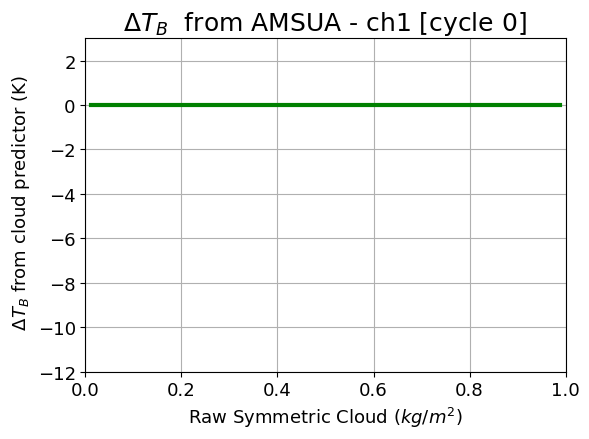

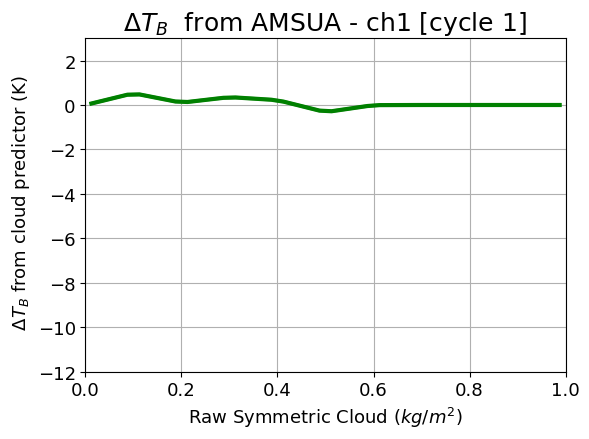

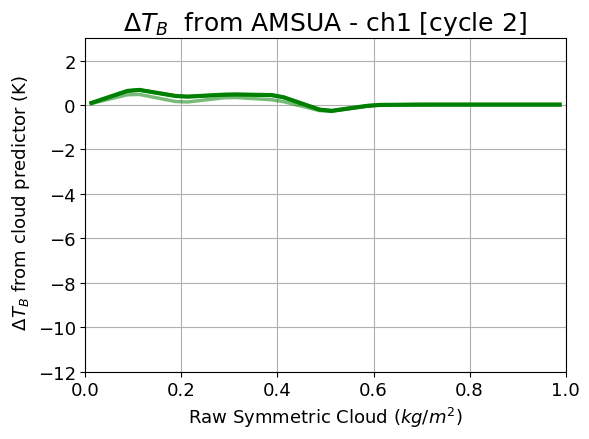

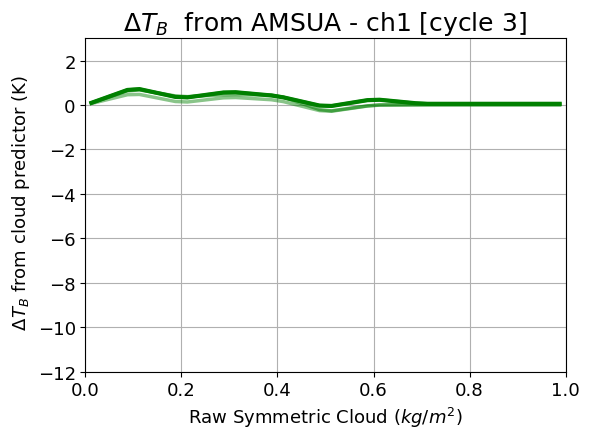

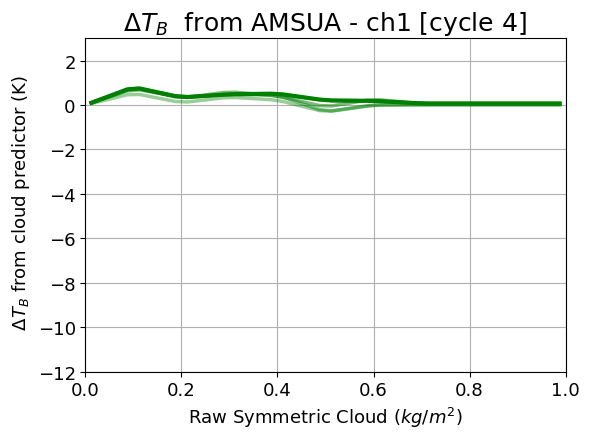

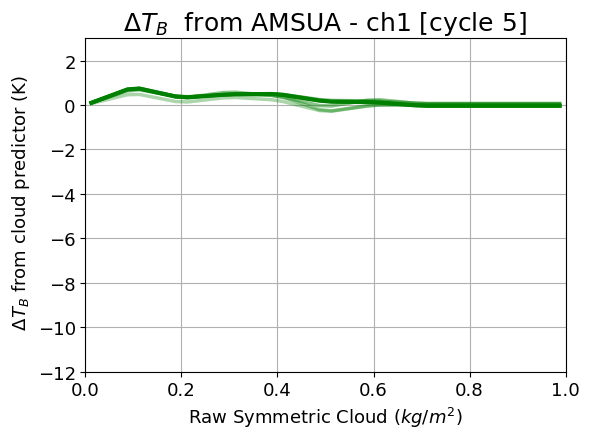

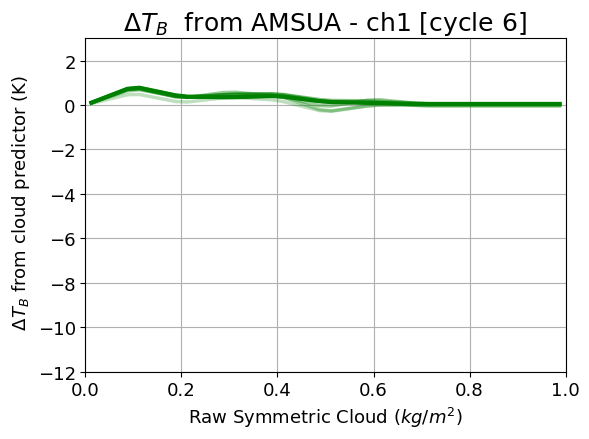

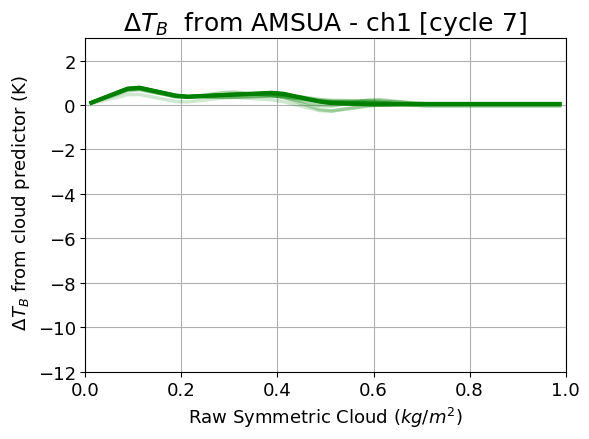

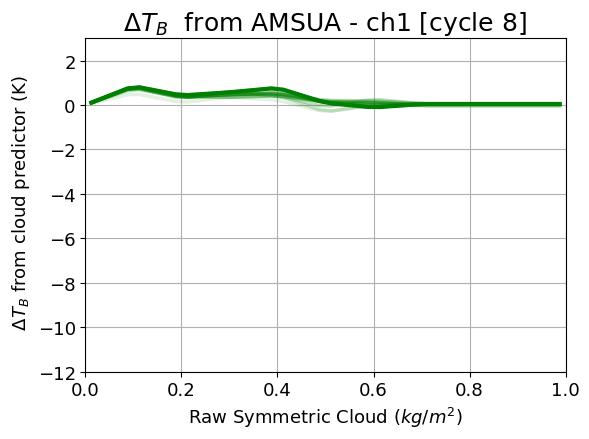

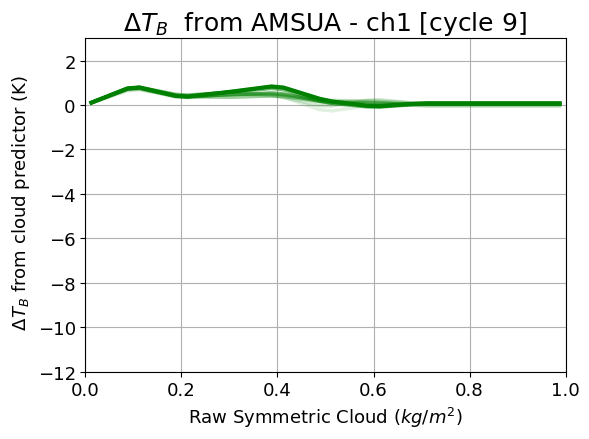

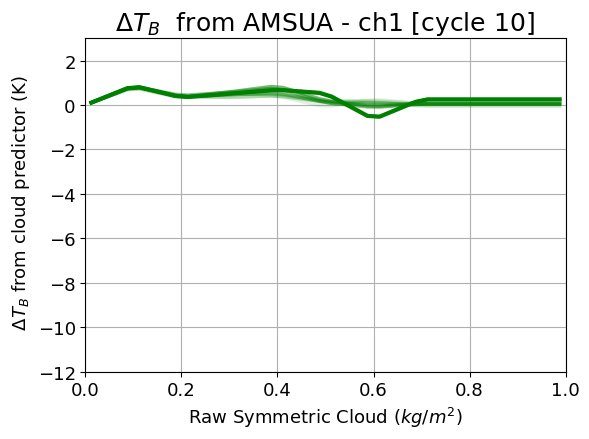

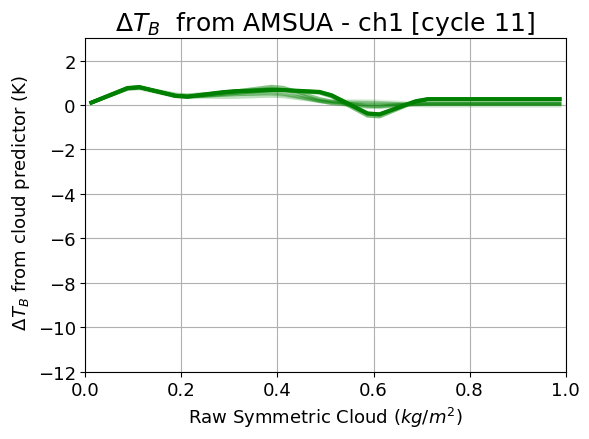

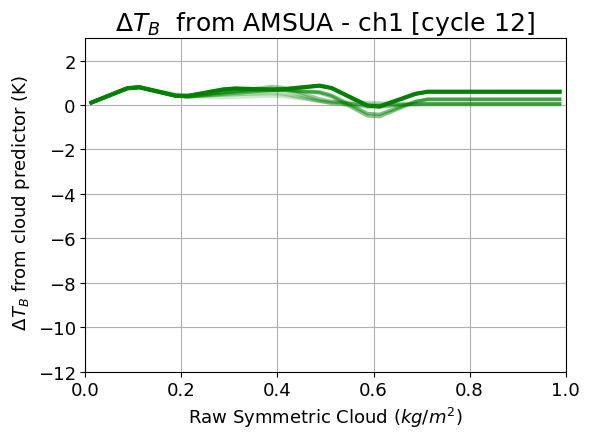

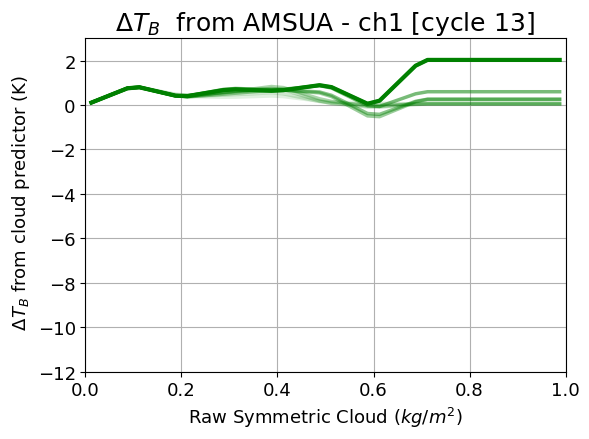

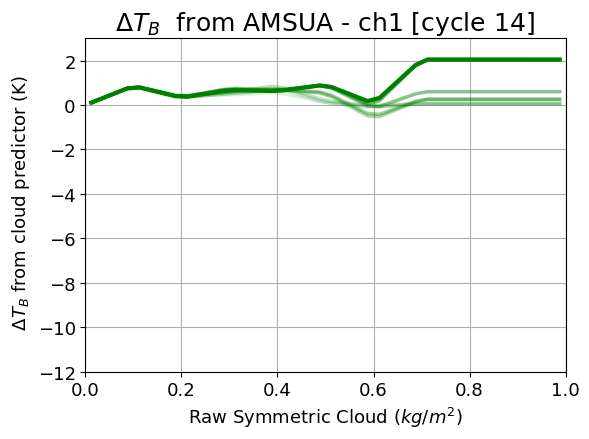

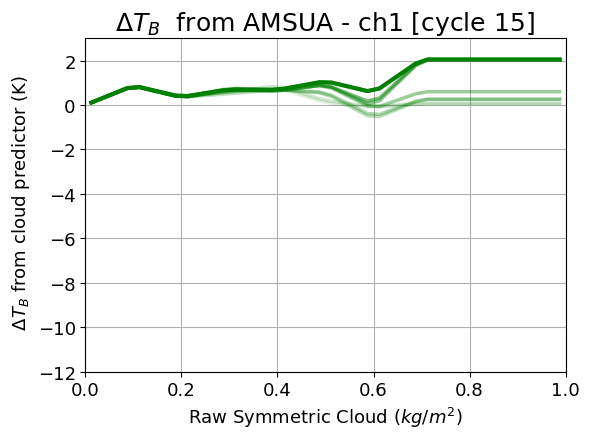

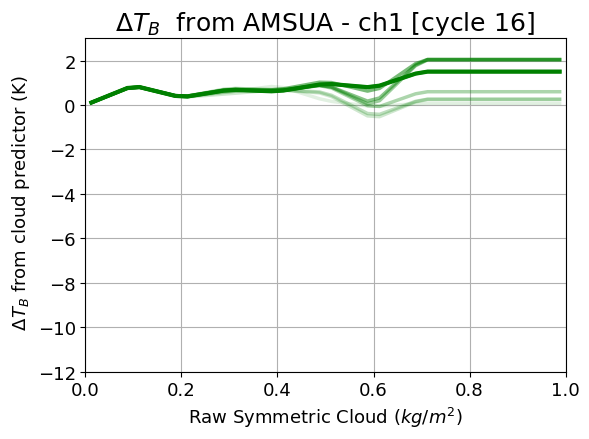

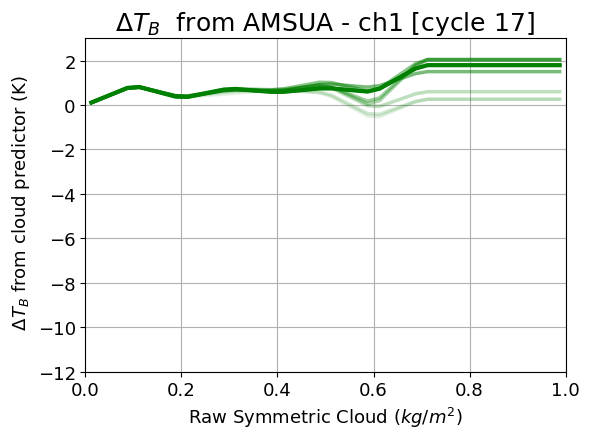

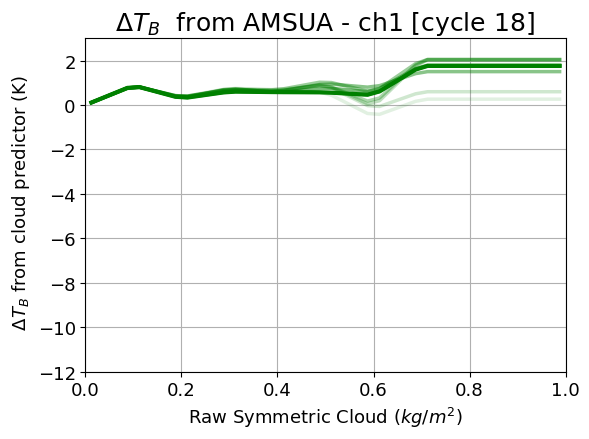

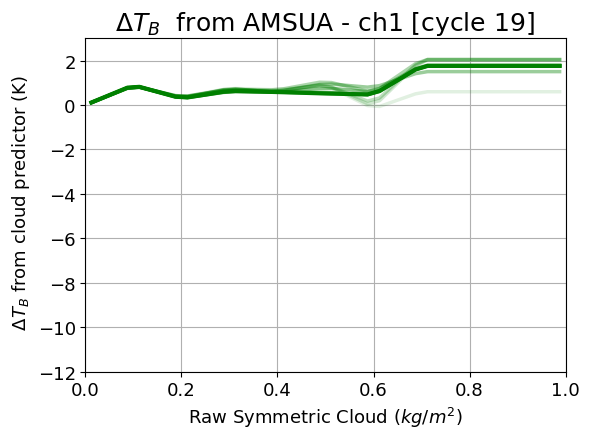

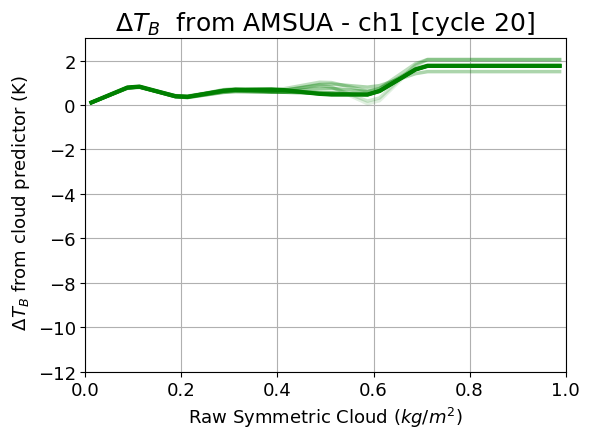

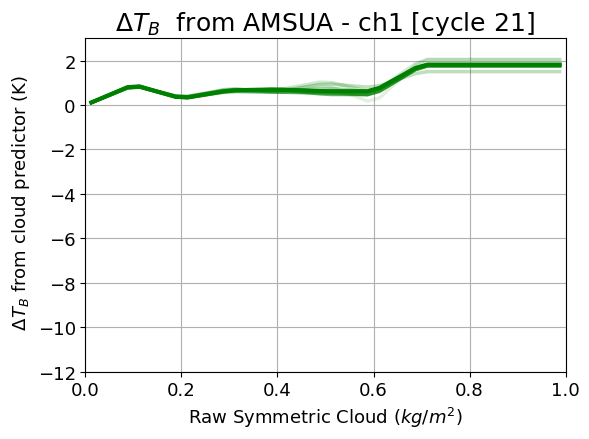

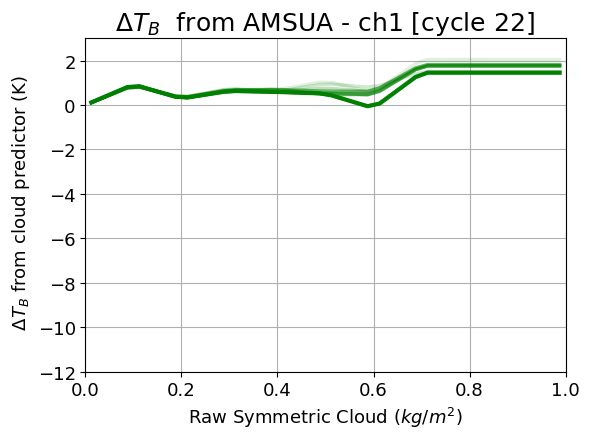

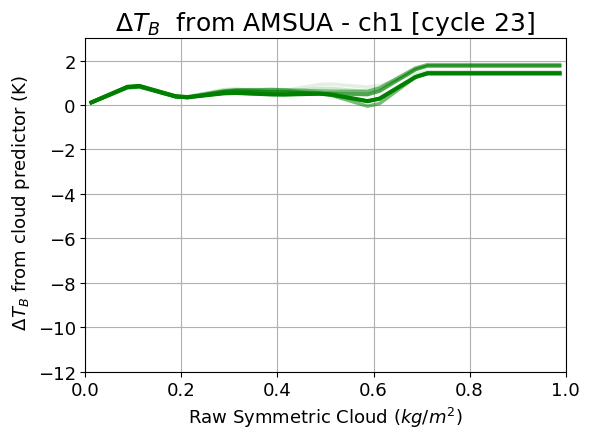

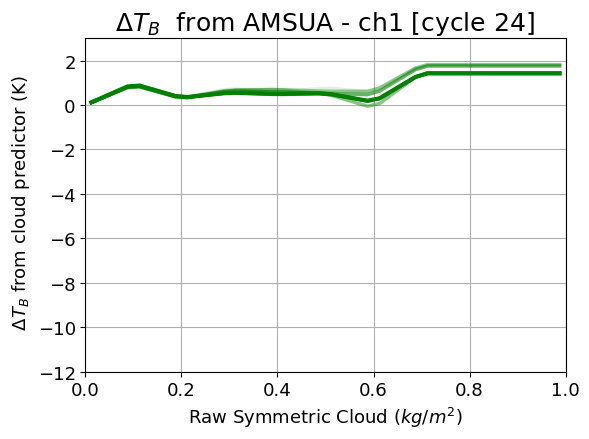

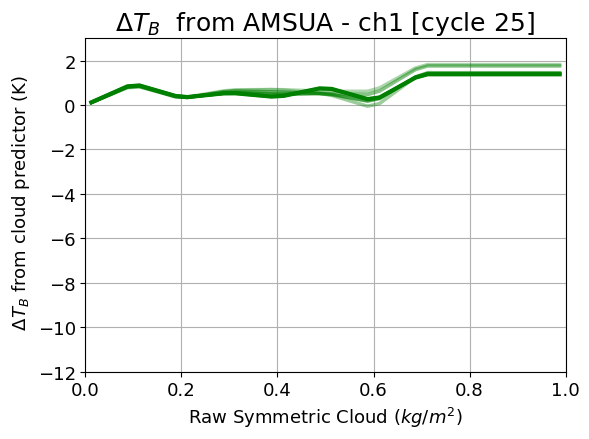

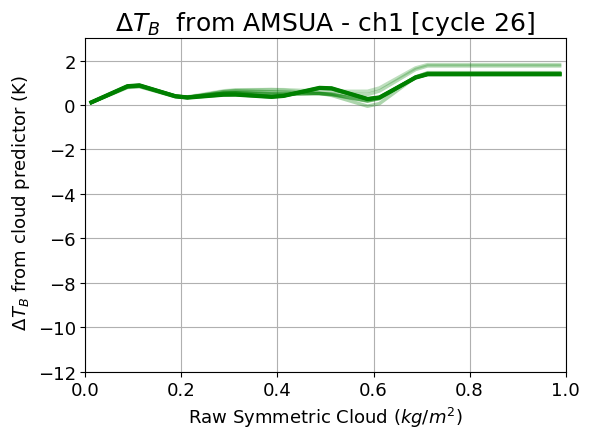

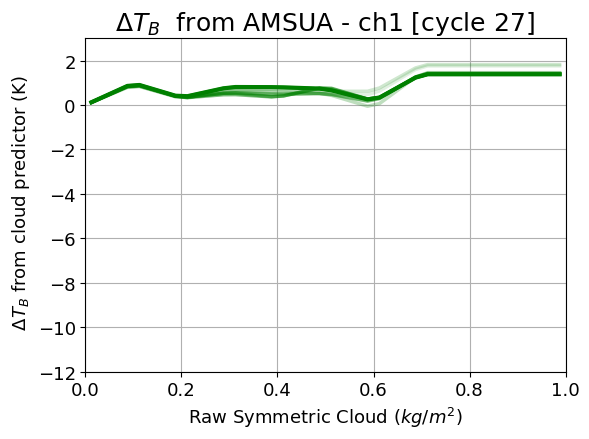

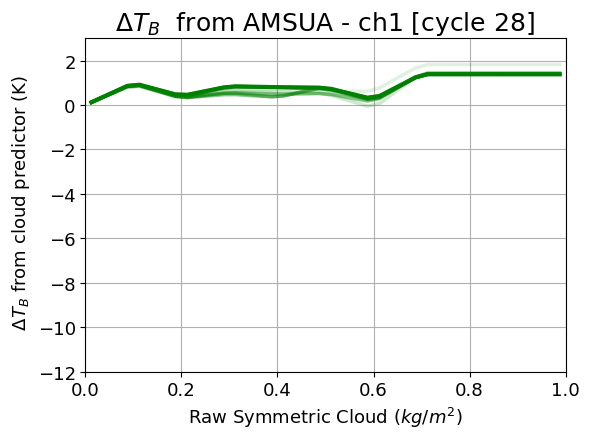

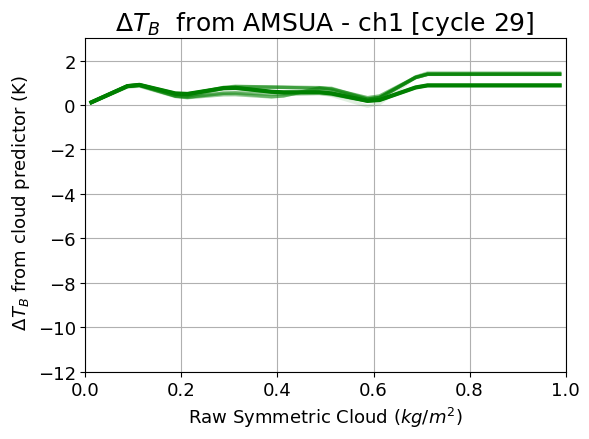

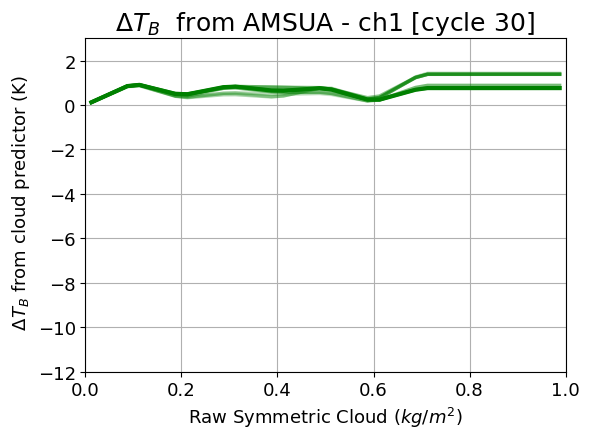

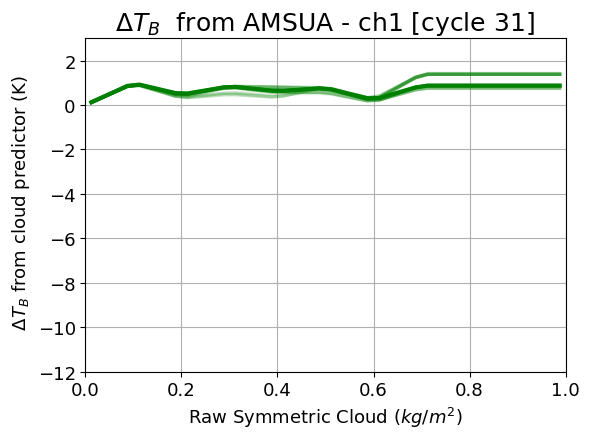

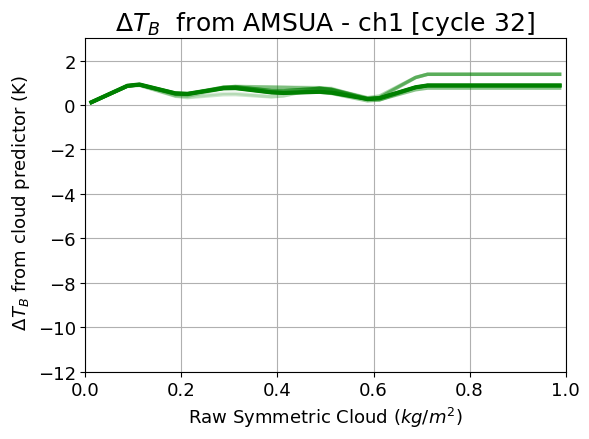

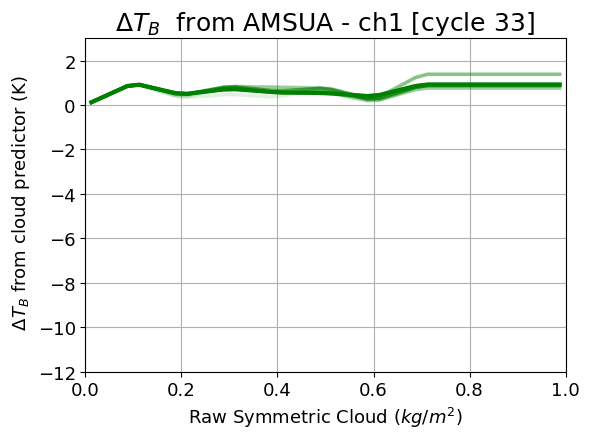

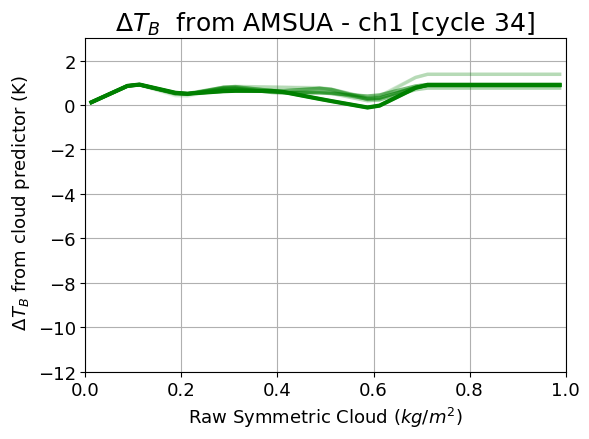

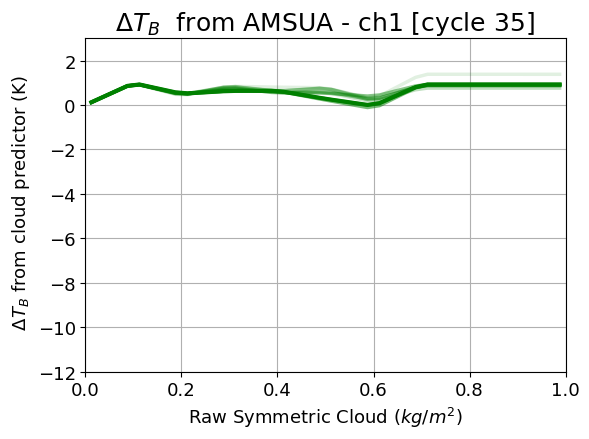

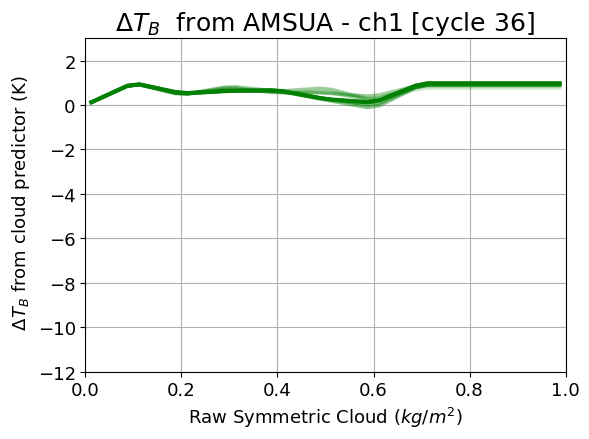

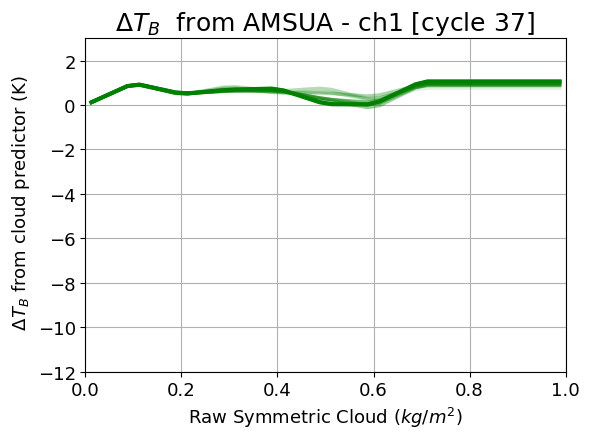

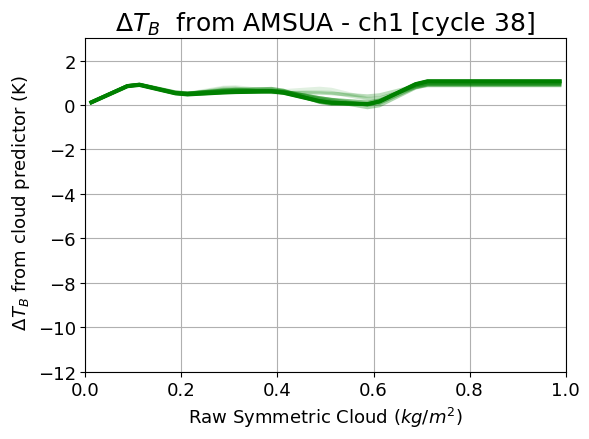

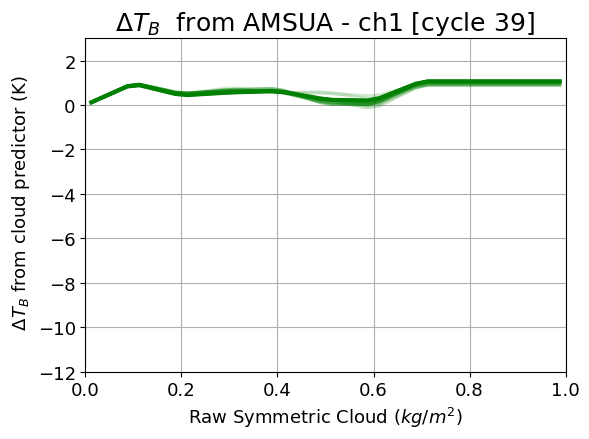

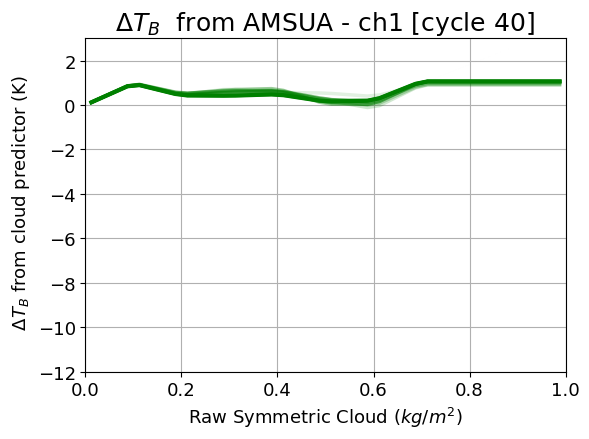

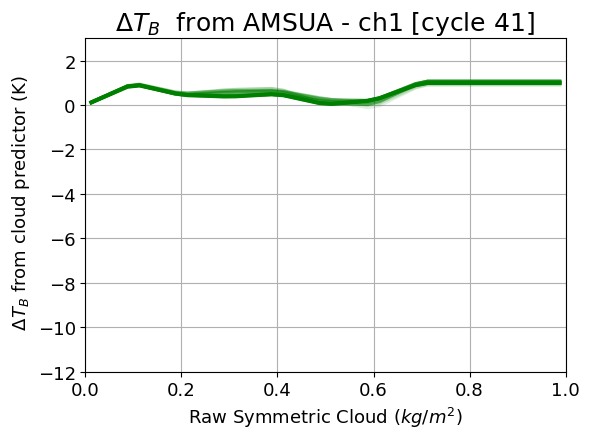

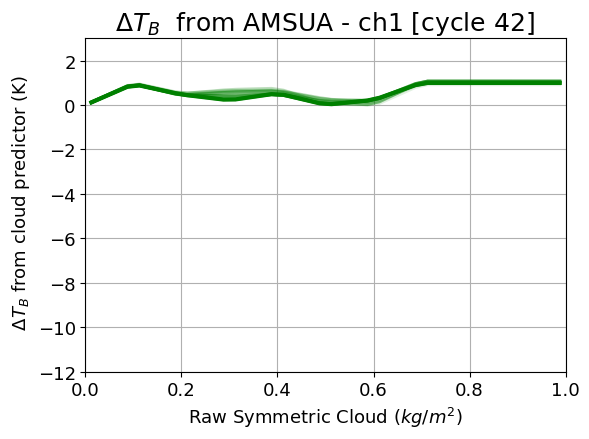

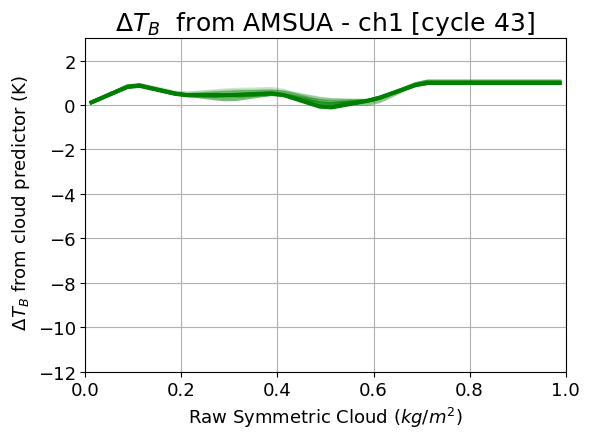

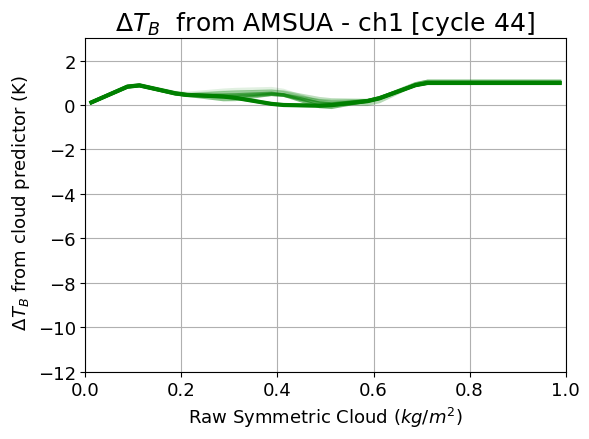

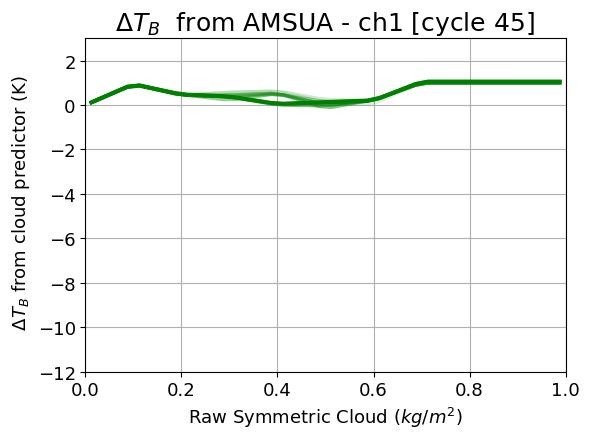

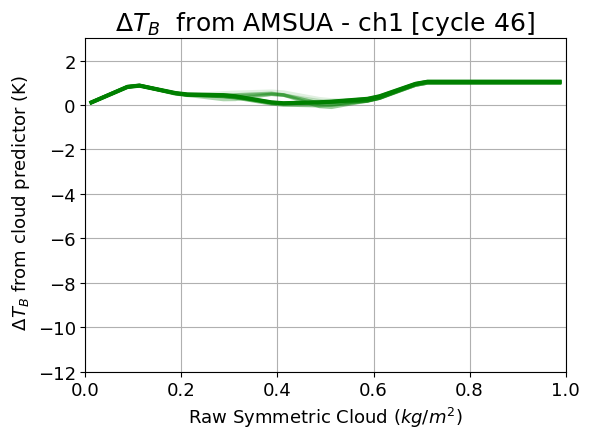

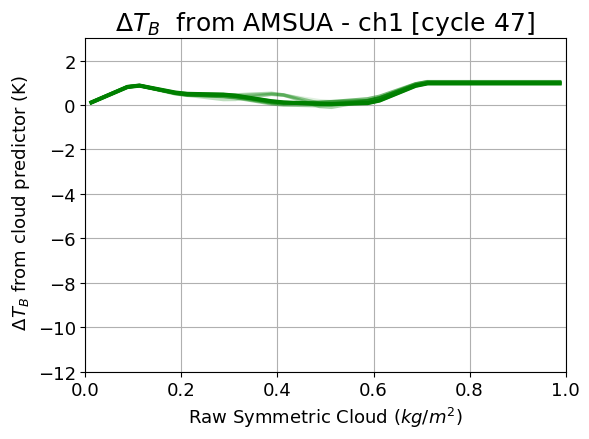

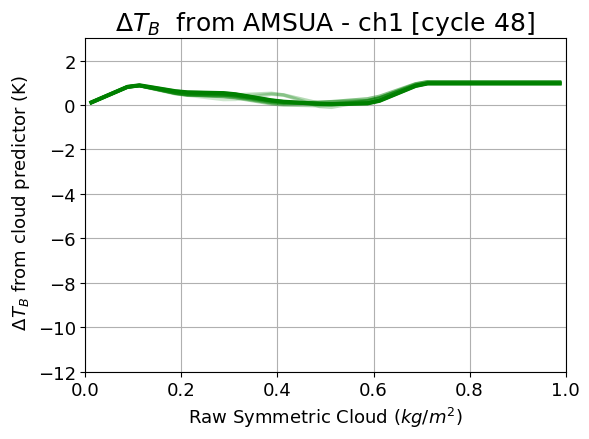

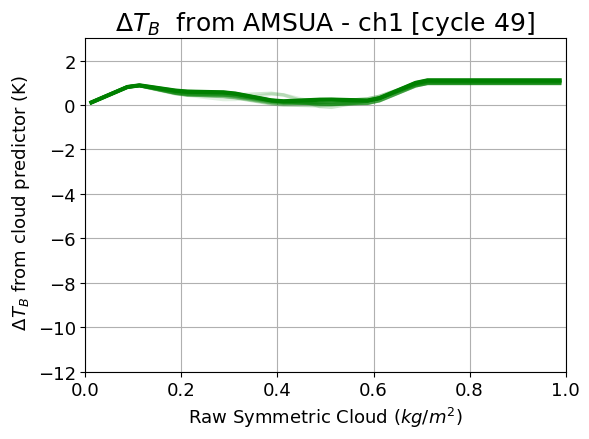

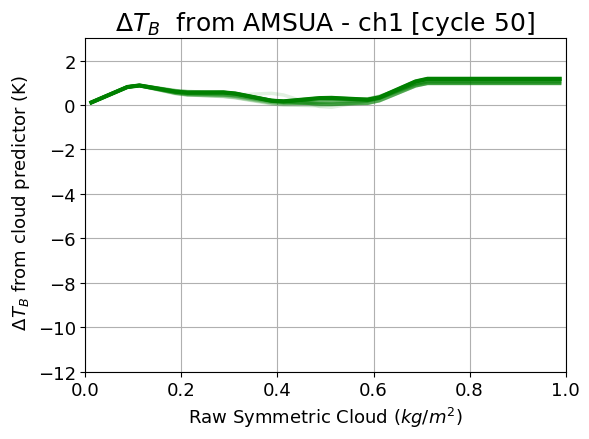

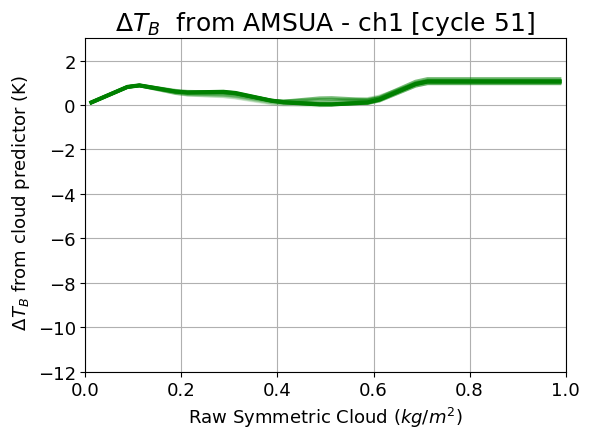

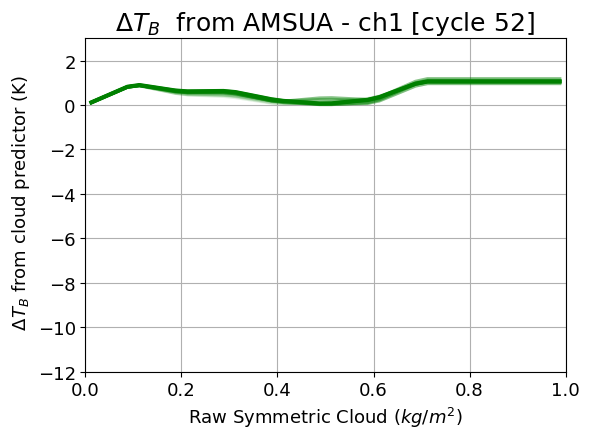

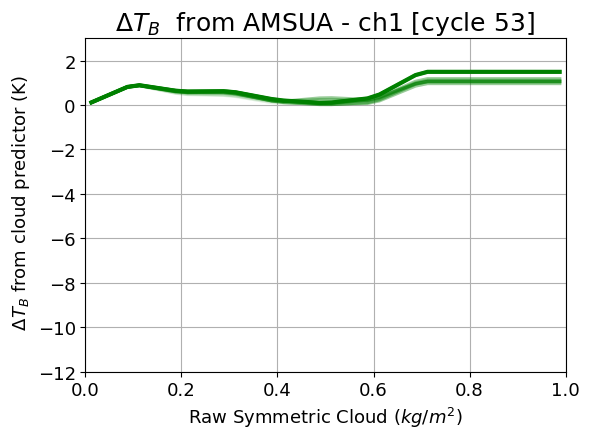

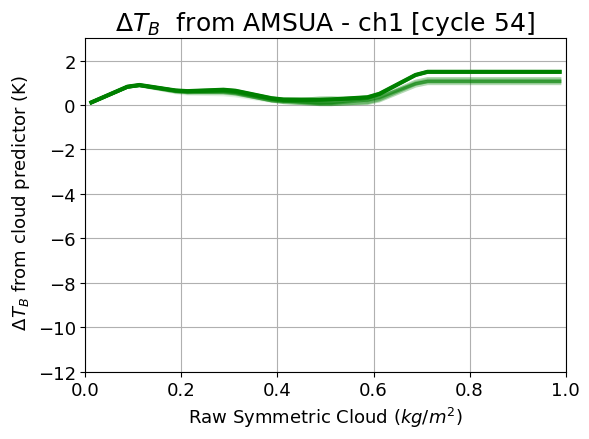

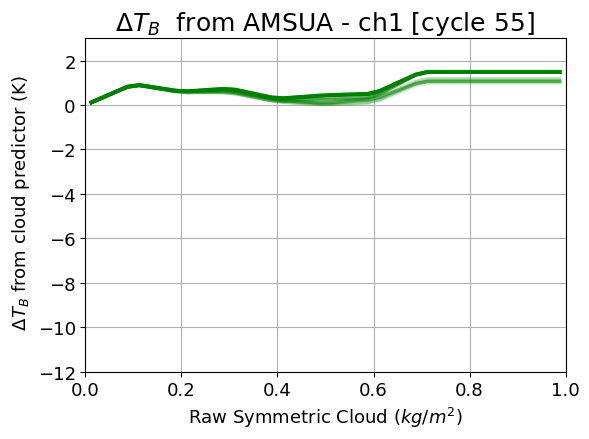

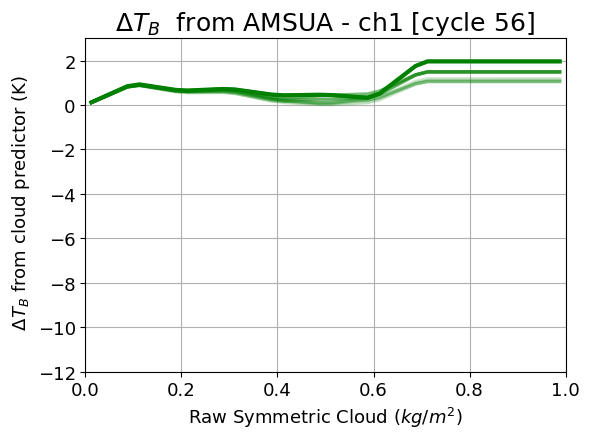

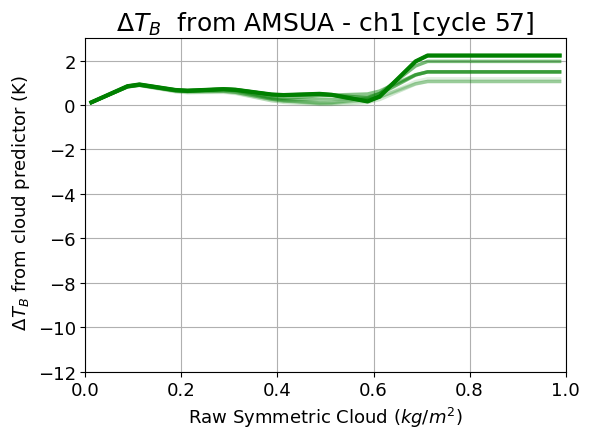

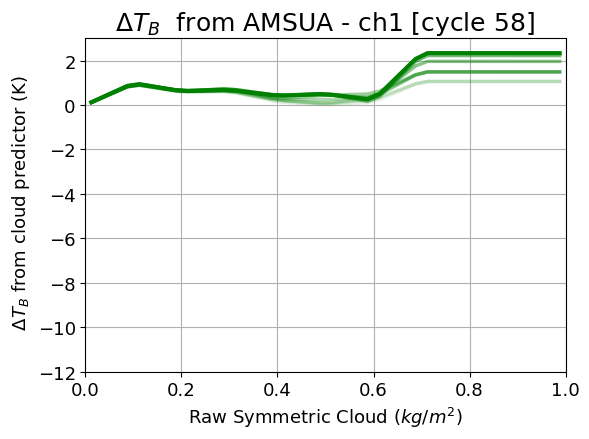

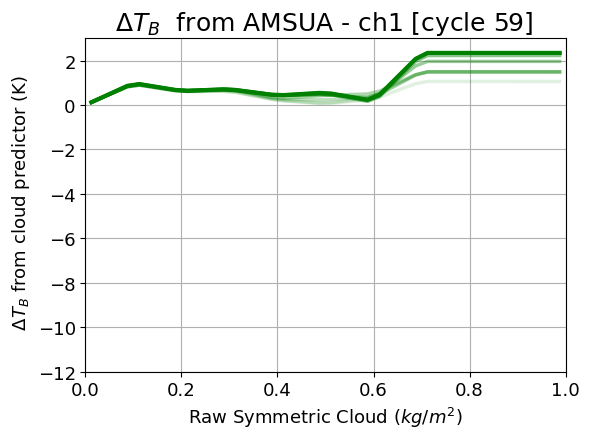

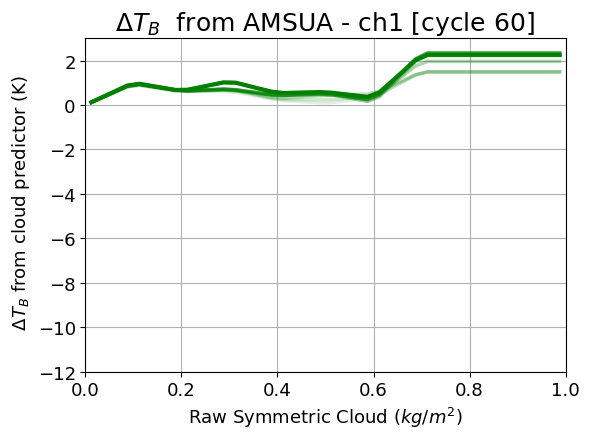

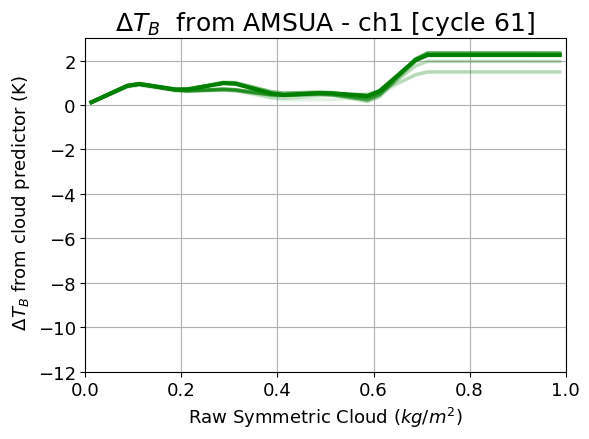

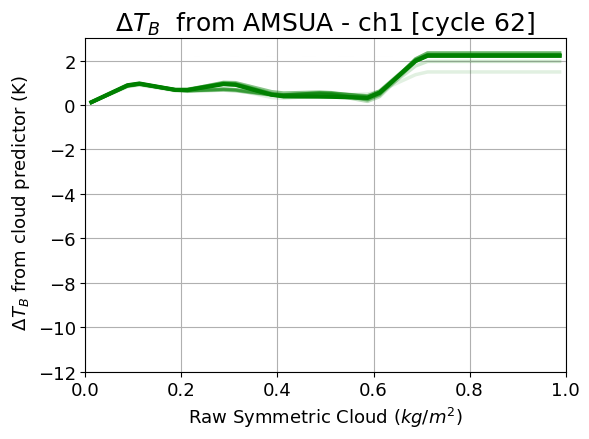

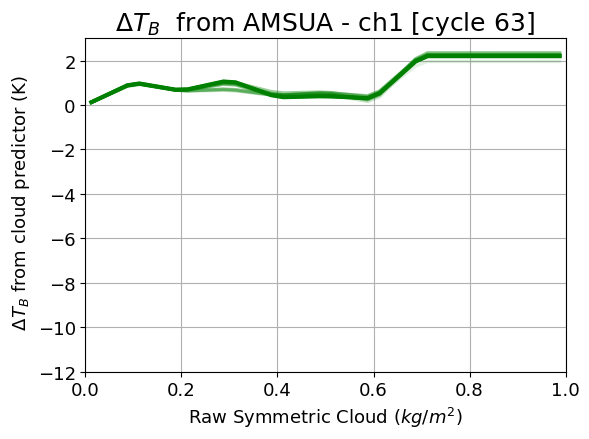

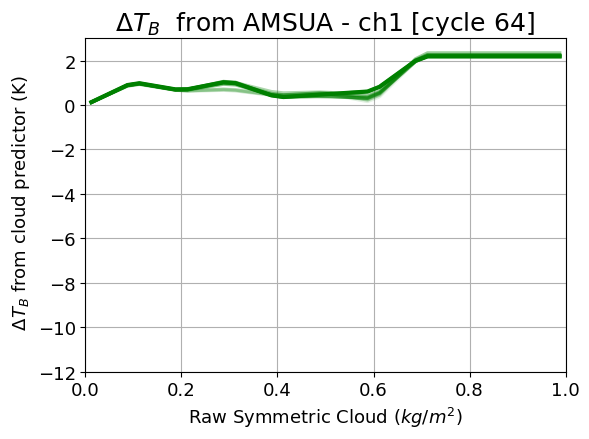

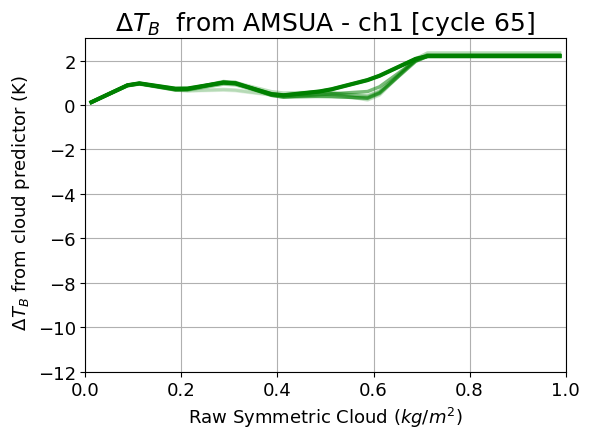

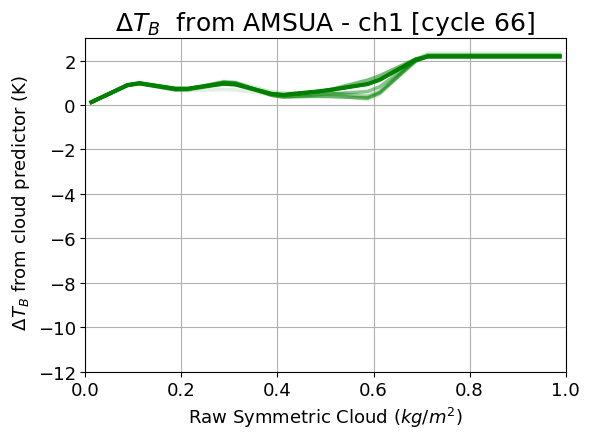

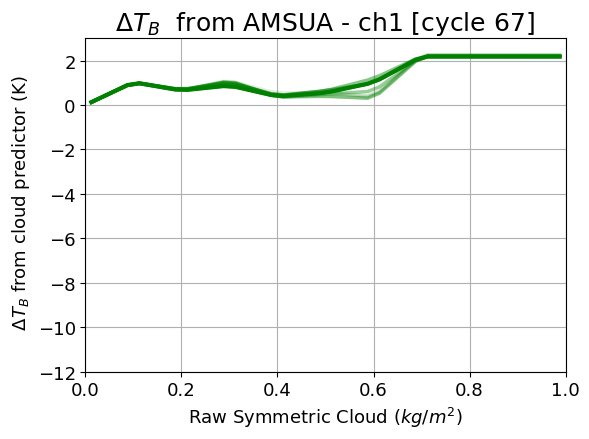

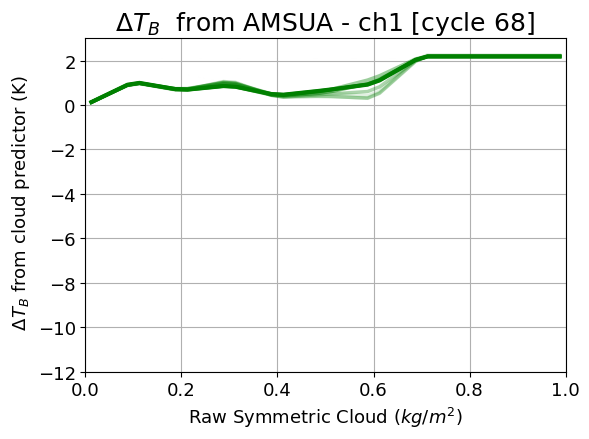

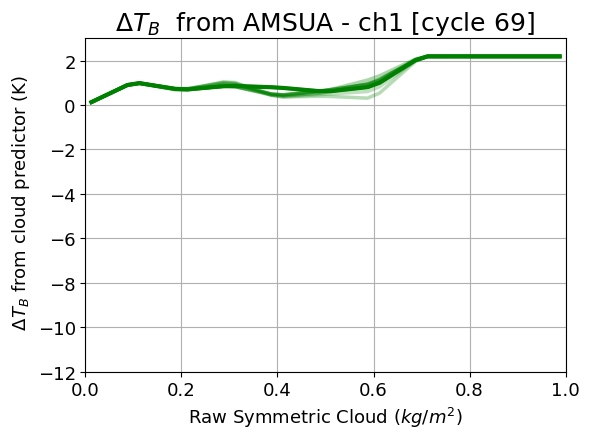

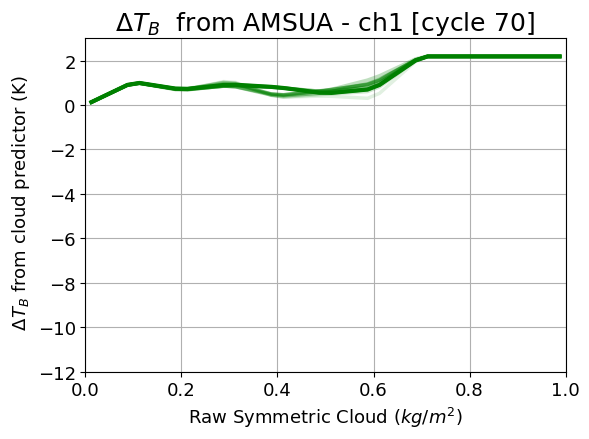

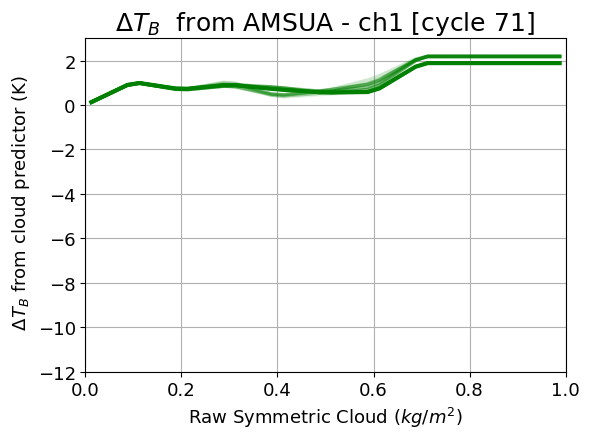

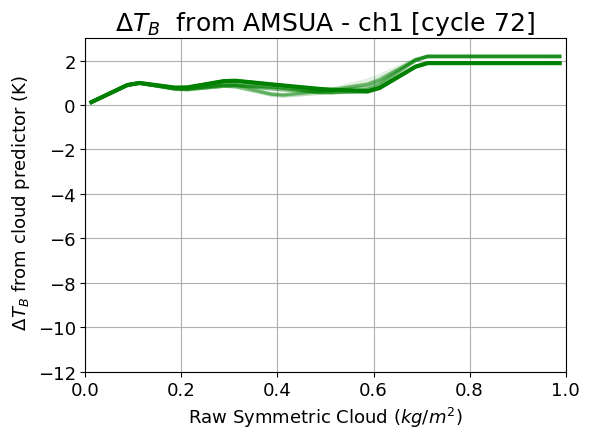

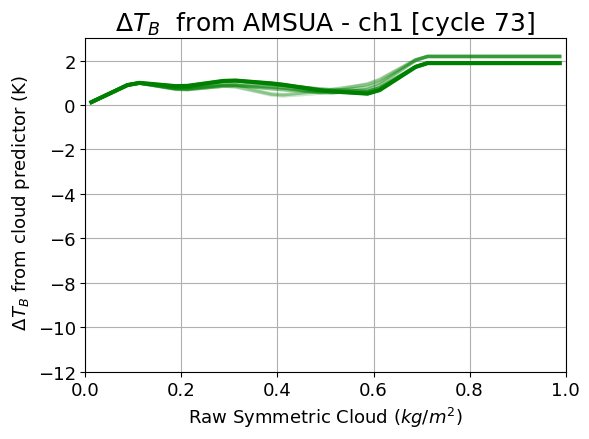

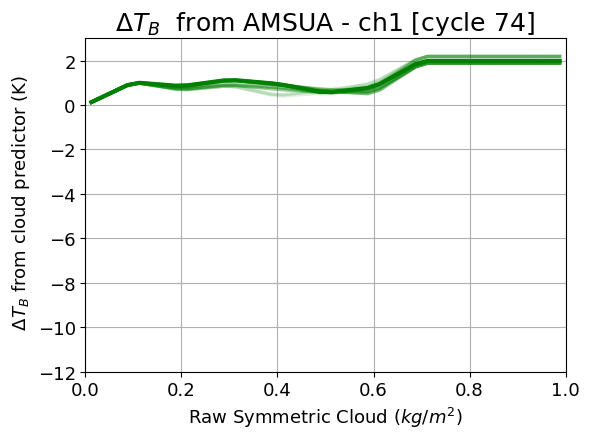

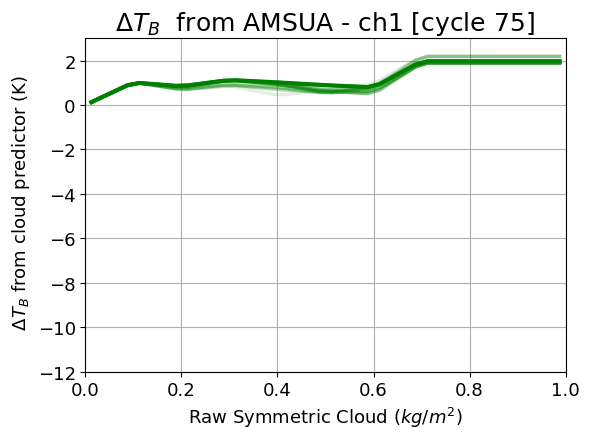

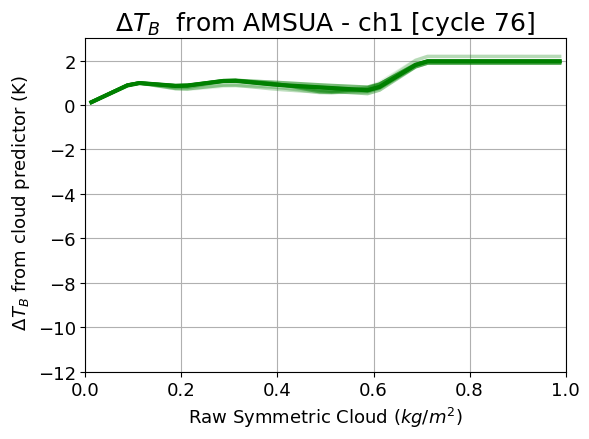

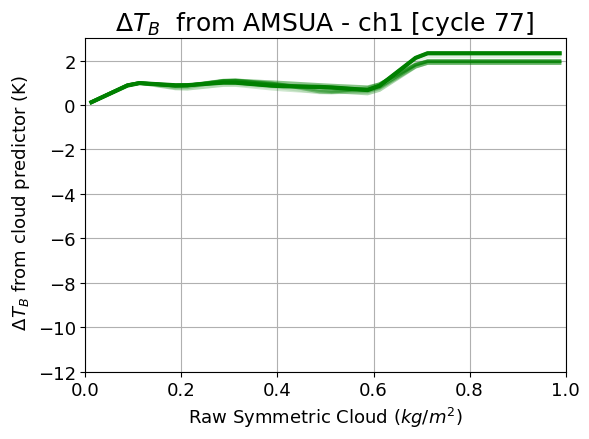

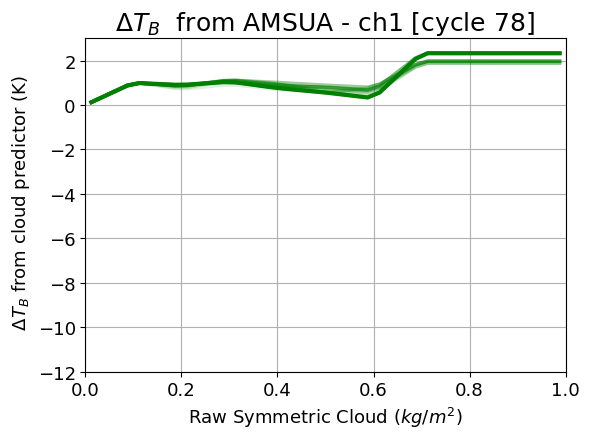

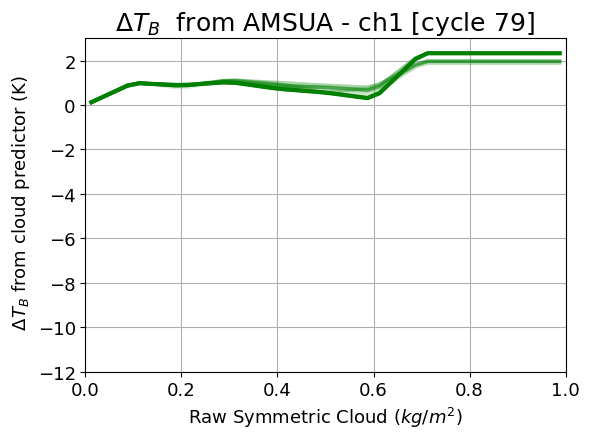

In [37]:
# plot the dTb at each cycle and save it (for making animation)

### read VarBC coefficients:
exp_list = ['full_sym_clwnbc', 'full_sym_tri']
sat='n19'
cld_pred = 'Symmetric Cloud'

fn_cloud={};
cloud_pred={};
datetime = [];

root='/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/varbc_coeff/compiled_stats'
fn_cloud['full_sym_clwnbc'] = f'{root}/full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_clwnbc/{instrument}_{sat}_{channel}_cloud'
cloud_pred['full_sym_clwnbc'] = [];
with open(fn_cloud['full_sym_clwnbc'], 'r') as file:
    for j, line in enumerate(file):
        parts = line.split()
        datetime.append(parts[0])
        cloud_pred['full_sym_clwnbc'].append( [float(parts[3]),float(parts[4]),float(parts[5]), float(parts[6])] ) 

fn_cloud['full_sym_tri'] = f'{root}/full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_tri_clwnbc/{instrument}_{sat}_{channel}_cloud'
cloud_pred['full_sym_tri'] = [];
with open(fn_cloud['full_sym_tri'], 'r') as file:
    for j, line in enumerate(file):
        parts = line.split()
        cloud_pred['full_sym_tri'].append( [float(parts[3]),float(parts[4]),float(parts[5]),float(parts[6]), \
                                            float(parts[7]),float(parts[8]),float(parts[9])] )

x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
    
nx = len(x_axis)
nt = len(cloud_pred['full_sym_clwnbc'])

yy = {};
yy['full_sym_clwnbc'] = np.zeros((nt,nx))
yy['full_sym_tri']    = np.zeros((nt,nx))

def triangular_piecewise_predictor(xin, xl, xc, xr):
    yout = np.zeros_like(xin)
    for i, xx in enumerate(xin):
        if xx <= xl:
            yout[i] = 0.0
        elif xl < xx <= xc:
            yout[i] = (xx - xl) / (xc - xl)
        elif xc < xx <= xr:
            yout[i] = (xx - xr) / (xc - xr)
        else:
            yout[i] = 0.0
    return yout

for tt in range(nt):
    exp = 'full_sym_clwnbc'
    yy[exp][tt,:] = cloud_pred[exp][tt][0]*x_axis      +\
                    cloud_pred[exp][tt][1]*x_axis**2   +\
                    cloud_pred[exp][tt][2]*x_axis**3   +\
                    cloud_pred[exp][tt][3]*x_axis**4
    
    exp = 'full_sym_tri'
    yy[exp][tt,:] = cloud_pred[exp][tt][0]*triangular_piecewise_predictor(x_axis, 0.0, 0.1, 0.2) +\
                    cloud_pred[exp][tt][1]*triangular_piecewise_predictor(x_axis, 0.1, 0.2, 0.3) +\
                    cloud_pred[exp][tt][2]*triangular_piecewise_predictor(x_axis, 0.2, 0.3, 0.4) +\
                    cloud_pred[exp][tt][3]*triangular_piecewise_predictor(x_axis, 0.3, 0.4, 0.5) +\
                    cloud_pred[exp][tt][4]*triangular_piecewise_predictor(x_axis, 0.4, 0.5, 0.6) +\
                    cloud_pred[exp][tt][5]*triangular_piecewise_predictor(x_axis, 0.5, 0.6, 0.7) +\
                    cloud_pred[exp][tt][6]*triangular_piecewise_predictor(x_axis, 0.6, 0.7, 1000)
    
    
### Plot

#for e, exp in enumerate(exp_list):

exp=exp_list[1]
e=1

for abs_t in range(80):
    
    fig, ax1 = plt.subplots(figsize=(6,4.5))
    
    ax1.plot(x_axis, yy[exp][abs_t,:],  color=expcolor[exp], linewidth=3)
    
    for tt in range(8):
        alpha = 0.6 - 0.55*tt/8
        
        if abs_t - tt >0:
            ax1.plot(x_axis, yy[exp][abs_t-tt,:],  color=expcolor[exp], linewidth=2.5, alpha=alpha)


    ax1.grid(True)
    ax1.set_xlim(0,1)
    ax1.set_ylim(-12,3)
    #ax1.set_ylim(vmin,vmax)
    ax1.set_xlabel(rf'Raw {cld_pred} ($kg/m^2$)', fontsize=13)
    ax1.set_ylabel(r' $\Delta T_B$ from cloud predictor (K)', fontsize=13)
    #ax1.legend(loc='best',fontsize=11.5)
    ax1.tick_params(axis='both', labelsize=13)

    ax1.set_title(rf'$\Delta T_B$  from {instrument.upper()} - {channel} [cycle {abs_t}] ',fontsize=18)
    plt.tight_layout()

    if save_figure:
        #plt.savefig(f"{fig_dir}/TB_inc_animation/{instrument}_{channel}_POLY_{abs_t}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{fig_dir}/TB_inc_animation/{instrument}_{channel}_TENT_{abs_t}.png", dpi=300, bbox_inches='tight')

    #plt.show()



In [28]:
yy['full_sym_clwnbc'].shape

(245, 40)